## Topic Diversity evaluation
**Intuition**: The clusters should be located as far away from each other as possible. Therefore, an evaluation metric of topic diversity can be calculated by evaluating the distance between topic cluster centroids. Finding the average of the minimum distance for each topic to another and maximising this value over different model configurations could yeild high quality topics. 

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from bertopic import BERTopic
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def topic_diversity_dataframe(topic_embeddings, topic_labels):
    """
    Make dataframe appropriate for evaluation of topic centroid embeddings.
    Standard procedure to get above arguments: 
    topic_embeddings: topic_model.topic_embeddings_
    topic_labels: topic_model.topic_labels_.values()
    """

    dis_matrix = cosine_distances(topic_embeddings)
    df_dis = pd.DataFrame(dis_matrix, columns=topic_labels, index=topic_labels)

    # Convert cosine distance matrix to pair-wise dataframe
    triangular_matrix = pd.DataFrame(np.triu(df_dis), columns=df_dis.columns, index=df_dis.columns)
    df_long = triangular_matrix.stack().reset_index()
    df_long.columns = ['pair_1', 'pair_2', 'cosine_distance'] # Rename columns
    df_long = df_long[df_long.cosine_distance !=0] # Remove rows with 0 cosine distance
    print('Dataframe shape:', df_long.shape)
    return df_long


def plot_topic_diversity(topic_diversity_dataframe, topic_embeddings, umap_metric='cosine', text_height=20):
    """
    topic_diversity_dataframe: must come from the function with same name. 
    topic_embeddings syntax: topic_model.topic_embeddings_
    """
    # Manipulate data for plotting
    min_edges = topic_diversity_dataframe.groupby("pair_1")["cosine_distance"].min()
    mapper = umap.UMAP(n_components=2, metric=umap_metric, random_state=42).fit_transform(topic_embeddings)

    # Plot topic diversity metric
    fig, axs = plt.subplots(1,2, figsize=(12, 5))
    fig.suptitle("BERT v1")

    # Plot min edge weight distribution
    sns.histplot(x=min_edges.values, kde=True, bins=20, ax=axs[0])
    axs[0].axvline(np.mean(min_edges.values), color="r", label="Mean")
    axs[0].set_title("Topic Diversity Distribution")
    axs[0].set_xlabel("Cosine distance to closest topic centroid")
    axs[0].text(x=np.mean(min_edges.values)+0.01, y=text_height, s=f"{np.mean(min_edges.values):.3}")
    axs[0].legend()

    # Plot dim reduce topic embeddings 
    plt.scatter(mapper[:,0], mapper[:,1])
    axs[1].set_title("Topic embeddings when reduced from 384 to 2 dims")
    axs[1].set_xlabel("Topic centroid pos. dim_1")
    axs[1].set_ylabel("Topic centroid pos. dim_2")

    plt.show()

Dataframe shape: (6555, 3)


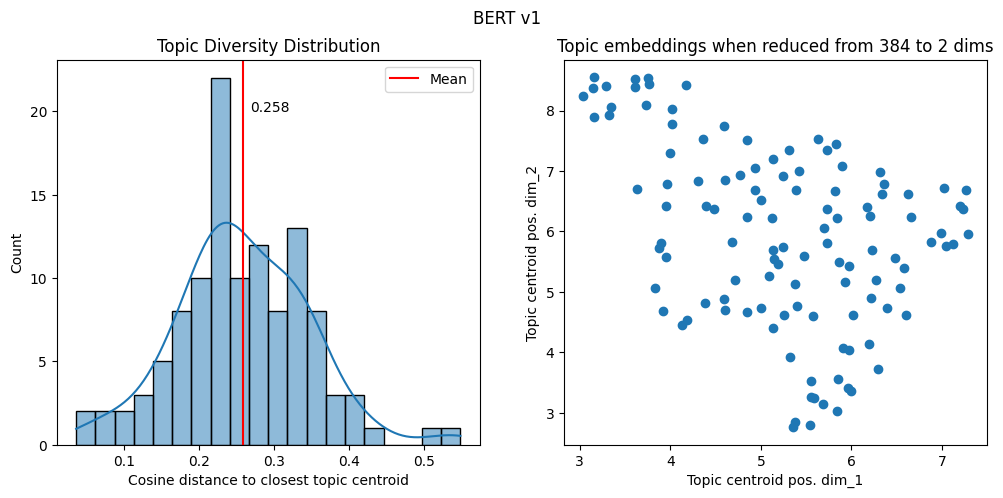

In [3]:
# Load model 
topic_model = BERTopic.load("BERT_v1")

# Make dataset and plot BERT v1
df_test = topic_diversity_dataframe(topic_model.topic_embeddings_, topic_model.topic_labels_.values())
plot_topic_diversity(df_test, topic_model.topic_embeddings_)